<font size="10">Learning Transformations to Saddle-Node Normal Forms</font>

<font size="4">In this notebook we train an autoencoder neural network architecture to identify a change of variable from the nonlinear mapping 
$x_{n+1} = (1 + \mu)x_n - \mathrm{e}^{x_n}$ to the normal form of the saddle-node bifurcation, $y_{n+1} = \nu + y_n + y_n^2$. The transformation is local to the bifurcation point $(x,\mu) = (1,\mathrm{e})$ and is approximated by the encoder $\eta(x,\mu)$ with the inverse transformation approximated by the decoder $\rho(y,\nu)$.</font>

<font size="4">This code was written by Mohit Sahu and accompanies the work in Section 6.3 of the book. <i>Data-Driven Methods for Dynamic Systems</i>. This script was adapted from the Tensorflow version by Jason J. Bramburger. We use PyTorch 2.3.0 to build the neural network</font>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import math
import matplotlib.pyplot as plt

In [ ]:
# Sample random points in the (x,mu) domain
N = 5000 # number of samples
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xn = torch.cat([torch.rand(N,1, dtype=torch.float32) - 0.5, 0.4*torch.rand(N,1, dtype=torch.float32)-0.2], dim=1).to(device) # Augmented to include state x_n and parameter mu
xnp1 = torch.zeros(N,2, dtype=torch.float32).to(device)

xnp1[:,0] = xn[:,0] + (xn[:,1] + math.exp(1)) * (xn[:,0] + 1) - torch.exp(xn[:,0] + 1) # forward iterate of the nonlinear map
xnp1[:,1] = xn[:,1]

In [ ]:
# Conjugacy neural network architecture
class Conjugacy(nn.Module):
    def __init__(self,
                 width = 100,
                 size_x = 2,
                 size_y = 2,
                 activation = nn.SELU(),
                 numblksIn = 1,
                 numblksOut = 1,
                 l1reg = 1e-15,
                 l2reg = 1e-15,
                 **kwargs):
        super(Conjugacy, self).__init__()
        self.width = width
        self.size_x = size_x
        self.size_y = size_y
        self.activation = activation
        self.numblksIn = numblksIn
        self.numblksOut = numblksOut
        self.l1reg = l1reg
        self.l2reg = l2reg

        # Encoder function
        encoder_layers = [nn.Linear(self.size_x, self.width), self.activation]
        for _ in range(self.numblksIn-1):  # adding more layers
            encoder_layers.append(nn.Linear(self.width, self.width))
            encoder_layers.append(self.activation)

        # Final layer to go to logistic map variables
        encoder_layers.append(nn.Linear(self.width, size_y))
        encoder_layers.append(self.activation)
        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder Function
        decoder_layers = [nn.Linear(self.size_y, self.width), self.activation]
        for _ in range(self.numblksOut-1):  # adding more layers
            decoder_layers.append(nn.Linear(self.width, self.width))
            decoder_layers.append(self.activation)

        # Final layer to go to tent map variables
        decoder_layers.append(nn.Linear(self.width, size_x))
        decoder_layers.append(self.activation)
        self.decoder = nn.Sequential(*decoder_layers)

        # Initialize weights in the model
        self.apply(self._initialize_weight)

    def _initialize_weight(self, module):
        if isinstance(module, nn.Linear):
            # apply a normal distribution to the weights and bias
            nn.init.normal_(module.weight, mean=0, std=0.1)
            nn.init.normal_(module.bias, mean=0, std=0.1)

    def forward(self, x):
        encoded = self.encoder(x)

        # Build forward iterates under normal form
        ynp1 = encoded[:,0] + encoded[:,1] + torch.square(encoded[:,0]) # Saddle-node normal form
        munp1 = encoded[:,1] # parameter step
        encoded_p1 = torch.stack([ynp1, munp1], dim = 1)
        decoded = self.decoder(encoded_p1)

        # Encoder/Decoder loss
        x_recon = self.decoder(encoded)
        conjugacy_loss = torch.mean(torch.square(x - x_recon))

        # f = rho of g of eta loss
        xnp1_1 = x[:,0] + (x[:,1] + math.exp(1.0)) * (x[:,0] + 1) - torch.exp(x[:,0] + 1) # forward iterate of the quadratic map
        xnp1_2 = x[:,1]
        xnp1 = torch.stack([xnp1_1, xnp1_2], axis = 1)
        prediction_loss = torch.mean(torch.square(decoded - xnp1))

        # Normal form loss
        xnp1_encoded = self.encoder(xnp1)
        normal_form_loss = torch.mean(torch.square(encoded_p1 - xnp1_encoded))

        # Enforce bifurcation point
        bf_pt_loss = torch.mean(torch.square(self.encoder(0*x)))

        # # L1L2 Regularization loss
        L1L2_loss = self.l1reg*sum(p.abs().sum() for p in self.encoder.parameters()) + self.l1reg*sum(p.abs().sum() for p in self.decoder.parameters())  # L1 Loss
        L1L2_loss += self.l2reg*sum(p.pow(2).sum() for p in self.encoder.parameters()) + self.l2reg*sum(p.pow(2).sum() for p in self.decoder.parameters())  # L2 Loss

        total_loss = conjugacy_loss + prediction_loss + normal_form_loss + L1L2_loss + bf_pt_loss

        return decoded, total_loss

In [ ]:
width = 100 # width of each NN layer
size_x = 2 # number of variables in the nonlinear exponential map (state + parameter)
size_y = 2 # number of variables in the normal form (state + parameter)
activation = nn.SELU() # nonlinear activation function at each NN layer
learning_rate = 0.0001
numblks_in = 2 # number of layers for the encoder NN
numblks_out = 2 # number of layers for the decoder NN

conjugacy = Conjugacy(width, size_x, size_y, activation, numblks_in, numblks_out).to(device)
optimizer = optim.Adam(conjugacy.parameters(), lr=learning_rate)
train_dataloader = DataLoader(xn, batch_size=32)

In [ ]:
def train(model, optimizer, xn, epochs=10, patience=100,loss_history=[]):
    model.train()
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        optimizer.zero_grad()
        decoded, loss = model(xn)

        loss.backward()
        optimizer.step()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

        if loss.item() < best_loss:
            best_loss = loss.item()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

        loss_history.append(loss.item())

    return loss_history

train(conjugacy, optimizer, xn, epochs=1000)

Epoch 1/1000, Loss: 0.5107898116111755
Epoch 2/1000, Loss: 0.4757206439971924
Epoch 3/1000, Loss: 0.44237786531448364
Epoch 4/1000, Loss: 0.4108313322067261
Epoch 5/1000, Loss: 0.38112202286720276
Epoch 6/1000, Loss: 0.3532749116420746
Epoch 7/1000, Loss: 0.3273038864135742
Epoch 8/1000, Loss: 0.30301806330680847
Epoch 9/1000, Loss: 0.28029462695121765
Epoch 10/1000, Loss: 0.259056955575943
Epoch 11/1000, Loss: 0.23920834064483643
Epoch 12/1000, Loss: 0.22073833644390106
Epoch 13/1000, Loss: 0.20357806980609894
Epoch 14/1000, Loss: 0.18755300343036652
Epoch 15/1000, Loss: 0.1726844310760498
Epoch 16/1000, Loss: 0.159206822514534
Epoch 17/1000, Loss: 0.1472080796957016
Epoch 18/1000, Loss: 0.13671115040779114
Epoch 19/1000, Loss: 0.12771554291248322
Epoch 20/1000, Loss: 0.12018568813800812
Epoch 21/1000, Loss: 0.11403103172779083
Epoch 22/1000, Loss: 0.10909276455640793
Epoch 23/1000, Loss: 0.10519184917211533
Epoch 24/1000, Loss: 0.10212485492229462
Epoch 25/1000, Loss: 0.0996747314929

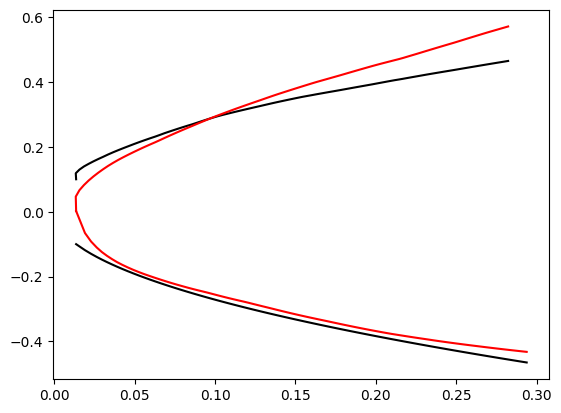

In [ ]:
# View trained network

# Check where fixed points in the normal form go to
sn_fixed_u = torch.zeros((100,2)) # Unstable fixed point in normal form
sn_fixed_s = torch.zeros((100,2)) # Stable fixed point in normal form
for n in range(100):
    sn_fixed_u[n,1] = -0.5*n/100
    sn_fixed_s[n,1] = sn_fixed_u[n,1]
    sn_fixed_u[n,0] = torch.sqrt(-sn_fixed_u[n,1])
    sn_fixed_s[n,0] = -torch.sqrt(-sn_fixed_u[n,1])

# Decode normal form fixed points
fixed_u = conjugacy.decoder(sn_fixed_u).cpu().detach()
fixed_s = conjugacy.decoder(sn_fixed_s).cpu().detach()

# Taylor expansion of fixed point values
true_fixed_u = -torch.sqrt(2*fixed_u[:,1]/math.exp(1.0)).cpu().detach()
true_fixed_s = torch.sqrt(2*fixed_u[:,1]/math.exp(1.0)).cpu().detach()

# Plot Taylor expansion of fixed points in bifurcation diagram
plt.plot(fixed_u[:,1],true_fixed_u,'k')
plt.plot(fixed_s[:,1],true_fixed_s,'k')

# Plot results
plt.plot(fixed_u[:,1],fixed_u[:,0],'r')
plt.plot(fixed_s[:,1],fixed_s[:,0],'r')

In [ ]:
# Loading the model
import tensorflow as tf

def loadModel(file_path, numblksIn=2, numblksOut=2, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    tf_model = tf.keras.models.load_model(file_path)

    conju_wt = tf_model.get_weights()
    conju_wt = [torch.tensor(cmc, dtype=torch.float32).to(device) for cmc in conju_wt]

    pytorch_model = Conjugacy(numblksIn=numblksIn, numblksOut=numblksOut).to(device)
    for i in range(numblksIn+1):
        # print(conju_wt[2*i].T[14,1])
        pytorch_model.encoder[2*i].weight = nn.Parameter(conju_wt[2*i].T)
        pytorch_model.encoder[2*i].bias = nn.Parameter(conju_wt[2*i+1])

    for i in range(numblksOut+1):
        pytorch_model.decoder[2*i].weight = nn.Parameter(conju_wt[2*(i+numblksIn+1)].T)
        pytorch_model.decoder[2*i].bias = nn.Parameter(conju_wt[2*(i+numblksIn+1)+1])

    return pytorch_model

conjugacy = loadModel( "../saved_conjugacy_networks/saddle_node")

c:\Users\mohit\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
